In [1]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
from datetime import datetime
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# import pcl
import pyntcloud

sys.path.append('/home/jovyan/work/obstacle-detection/')
sys.path.append('/home/jovyan/work/boxes_vis/git/obstacle-detection/')

In [2]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
# Segments id -> name mapping
seg_lst = config['segments']

In [4]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [5]:
num ='066'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [6]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
print('Scan have:')
for seg in unq:
    if seg in list(seg_lst.keys()):
        print(seg, seg_lst[seg])

Scan have:
0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
72 terrain
40 road
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle


### Segmentated Point Cloud

In [ ]:
cloud = pd.DataFrame(scan[:, :3], columns=['x', 'y', 'z'])
cloud['seg_id'] = label
pcloud = pyntcloud.PyntCloud(cloud)
pcloud.plot(use_as_color='seg_id', cmap="cool", backend="pythreejs")

![lol](img/step1.png)

### Roi filtering

In [ ]:
from pipeline import common
cloud = common.roi_filter(cloud,  min_x=0, max_x=45, 
                                   min_y=-14, max_y=14,
                                   min_z=-2, max_z=1)
pcloud = pyntcloud.PyntCloud(cloud)
pcloud.plot(use_as_color='seg_id', cmap="cool", backend="pythreejs")

![lol](img/step2.png)

### Non-obstacle filtering

In [ ]:
cloud = common.obstacle_filter(cloud, obstacle_lst)
pcloud = pyntcloud.PyntCloud(cloud)
pcloud.plot(use_as_color='seg_id', cmap="cool", backend="pythreejs")

![lol](img/step3.png)

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [71]:
from pipeline import common
common = imp.reload(common)

def pipeline(scan, label, obstacle_lst, verbose=False, OBBoxes=False, exec_time=False, **params):
    
    """ ROI filtering """
    ##################################################################################################
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
    pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)
    roi_time = (datetime.now() - start_time).total_seconds()
    ###################################################################################################
    
    """ Obstacles filtering """
    ###################################################################################################
    start_time = datetime.now()
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    obstacle_time = (datetime.now() - start_time).total_seconds()
    ###################################################################################################
    
    if len(pcloud) > 200:
        
        # Getting voxel grid
        start_time = datetime.now()
        voxel_time = (datetime.now() - start_time).total_seconds()

        """ Сlustering obstacles """
        ###############################################################################################
        start_time = datetime.now()
        clusterer = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], 
                           algorithm='auto', leaf_size=params['leaf_size'], n_jobs=-1)
        clusterer.fit(pcloud[['x', 'y', 'z']])
        pcloud['cluster_id'] = clusterer.labels_
        cluster_time = (datetime.now() - start_time).total_seconds()
        ###############################################################################################
        
        """ Getting bounding boxes coord """
        ###############################################################################################
        start_time = datetime.now()
        pcloud['norm'] = np.sqrt(np.square(pcloud[['x', 'y', 'z']]).sum(axis=1))
        cluster_data = pd.DataFrame.from_dict({'x': [], 'y': [], 'z': [],'cluster_id': []})
        clusters = []
        for _id in sorted(pcloud['cluster_id'].unique()):
            if _id == -1 or not 50 < len(pcloud[pcloud['cluster_id'] == _id]) < 5000:
                continue
            tcluster = pcloud[pcloud['cluster_id'] == _id]
            tcluster = common.outlier_filter(tcluster, verbose=False)
            cluster_data = cluster_data.append(tcluster)
            if OBBoxes:
                obb = common.get_OBB(tcluster[['x', 'y', 'z']])
                clusters.append(obb)
        if not OBBoxes:
            clusters = cluster_data.groupby(['cluster_id']).agg({ 'x': ['min', 'max'],
                                                                  'y': ['min', 'max'],
                                                                  'z': ['min', 'max'] }).values
        bb_time = (datetime.now() - start_time).total_seconds()
        ###############################################################################################
    else:
        clusters, cluster_data = [], np.empty((0, 0))
        voxel_time, cluster_time, bb_time = 0, 0, 0
        
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.5f}s'.format(roi_time))
        print('\n - Filtering obstacles: {:.5f}s'.format(obstacle_time))
        print('\n - Voxel grid: {:.5f}s'.format(voxel_time))
        print('\n - Clustering: {:.5f}s'.format(cluster_time))
        print('\n - Min-max cluster points: {:.5f}s \n'.format(bb_time))
        
    if exec_time:
        return clusters, cluster_data, {'roi_time': roi_time,
                                        'filter_obstacle_time': obstacle_time,
                                        'voxel_grid_time': voxel_time,
                                        'clustering_time': cluster_time,
                                        'outlier_filter_bbox_time': bb_time}
    else:
        return clusters, cluster_data

## Pipeline implementation

In [72]:
%%time 
num = '000'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 3.25 ms, sys: 7.65 ms, total: 10.9 ms
Wall time: 50.3 ms


In [55]:
%%time
params = {
          'roi_x_min': 0, 'roi_x_max': 45,
          'roi_y_min': -14, 'roi_y_max': 14,
          'roi_z_min': -2, 'roi_z_max': 1,
          'eps': 0.65, 'min_samples': 6, 'leaf_size': 120,
          'OBBoxes': True}

clusters, cluster_data, time_exec = pipeline(scan, label, obstacle_lst, verbose=True, 
                                    exec_time=True, **params)

Execution time:

 - ROI filtering: 0.01387s

 - Filtering obstacles: 0.05964s

 - Voxel grid: 0.00000s

 - Clustering: 0.20575s

 - Min-max cluster points: 0.06232s 

CPU times: user 333 ms, sys: 2.37 ms, total: 336 ms
Wall time: 343 ms


In [37]:
silhouette_score(cluster_data[['x', 'y', 'z']], cluster_data['cluster_id'])

0.8607451873305759

In [19]:
%timeit clusters, cluster_data = pipeline(scan, label, obstacle_lst, verbose=False, **params)

555 ms ± 4.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
len(clusters)

7

### Visualize clusters

In [ ]:
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

![lol](img/clustering_step.png)

### Visualize bounding boxes
use our visualize tool based on Semantic KITTI kit <br>
start as 
```python ./visualize.py --sequence 00 --dataset path\to\obstacle-detection\dataset -b```

![lol](img/bounding_boxes_step.png)

In [212]:
# box_coord_list = common.get_bounding_boxes(pd.DataFrame(clusters))
common = imp.reload(common)
box_coord_list = common.get_optimal_bboxes(cluster_data)

5.0 (3, 3)
7.0 (3, 3)
9.0 (3, 3)
11.0 (3, 3)
12.0 (3, 3)
13.0 (3, 3)


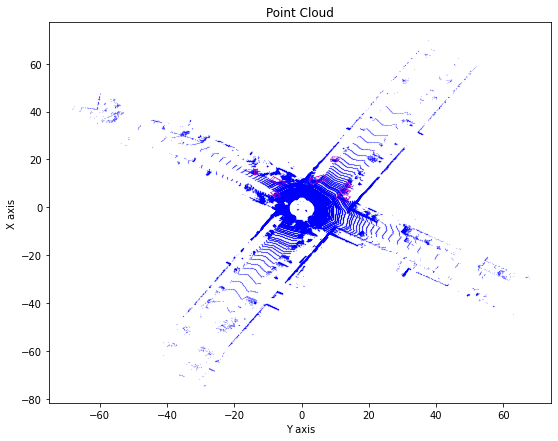

In [302]:
%matplotlib inline
from scripts import draw
draw = imp.reload(draw)
f = plt.figure(figsize=(9, 7))
axes = [1, 0]
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [296]:
pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), columns=['x', 'y', 'z', 'seg_id'])
%time cloud = common.obstacle_filter(pcloud, obstacle_lst)

Filter required segments
Point size before: 123177 and after filtering: 14118
CPU times: user 154 ms, sys: 126 µs, total: 154 ms
Wall time: 154 ms


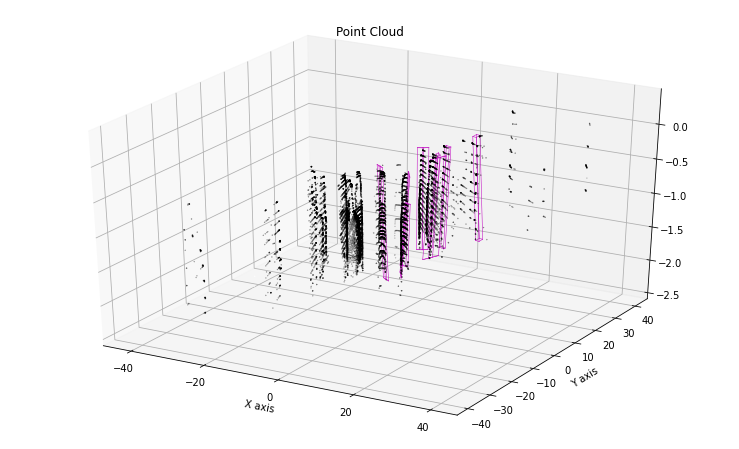

In [297]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [0, 1, 2]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(cloud.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

## Grid Search Optimization

In [1485]:
help(test.grid_search_optimization)

Help on function grid_search_optimization in module scripts.test:

grid_search_optimization(scan, label, obstacle_lst, pipeline, params, verbose=True)
    Grid Search of hyperparametrs for optimization of executional time of pipeline
    
    scan: numpy.array,
    An N X 3 array of point cloud from LIDAR
    
    label: numpy.array,
    A list of segmentation labels respectively
    
    obstacle_lst: list,
    A list of obstacles id
    
    pipeline: function,
    An obstacle-detection pipeline function
    
    params: dict,
    A dictionary of params range that is reqired to search
    
    verbose: bool, optional, defualt True
    Whether or not print info during execution.



In [38]:
from scripts import test
test = imp.reload(test)
range_params  = { 'roi_x_min': [0], 'roi_x_max': [45],
                  'roi_y_min': [-14], 'roi_y_max': [14],
                  'roi_z_min': [-2], 'roi_z_max': [1],
                  'eps': [0.5, 0.55, 0.65, 0.7], 'min_samples': [4, 5, 6, 7, 8], 
                  'leaf_size': [75, 100, 120, 150, 200, 300]}  
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline, 
                                              range_params, score=True, verbose=False)

In [39]:
time_ex_lst = {k: v  for k, v in time_exec_lst.items() if v[-1] > 0.55} 
sorted_exec_dct = {k: v for k, v in sorted(time_ex_lst.items(), key=lambda item: item[1][0], reverse=False)}

In [ ]:
n = 3
for i, key in enumerate(sorted_exec_dct):
    if i == n:
        break
    print(key,'Time and n clusters', sorted_exec_dct[key])

### Getting bounding boxes and grep statistics for sequence 

In [84]:
import glob
seq = '02'
scan_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  468


In [85]:
from scripts import test
test = imp.reload(test)

In [86]:
%%time
# n_scan = -1
write_path = '../dataset/sequences/' + seq + '/clusters/'
# write_path = None
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                                        pipeline, write_path=write_path, 
                                                        OBB=True, detailed=True, write_seg_id=True,
                                                        **params)


CPU times: user 1min 16s, sys: 3.49 s, total: 1min 20s
Wall time: 1min 49s


In [81]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

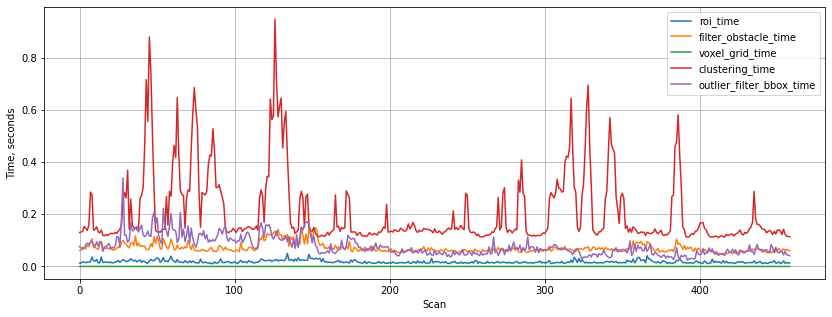

In [62]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.show()

In [63]:
time_stat = list(exec_time_dct.values())
print('Min process time {}s'.format(min(time_stat)))
print('Mean process time {}s'.format(np.mean(time_stat)))
print('Std process time {}s'.format(np.std(time_stat)))
print('Max process time {}s'.format(max(time_stat)))

Min process time 0.220915s
Mean process time 0.3832200305010893s
Std process time 0.16299711899987834s
Max process time 1.227007s


In [64]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

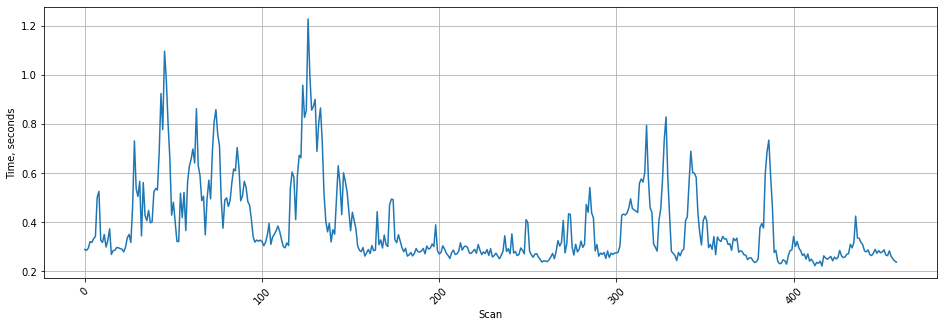

In [65]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Grep statistics of execution time for several observations

In [394]:
exec_lst = []
n_epoch = 5
for i in range(n_epoch):
    bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                                            pipeline, write_path=None, 
                                                            write_rotated=False, detailed=True, **params)
    exec_lst.append(exec_time_dct)

In [395]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append(list(epoch.values()))
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [396]:
ox = [int(x)for x in exec_lst[0].keys()]
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

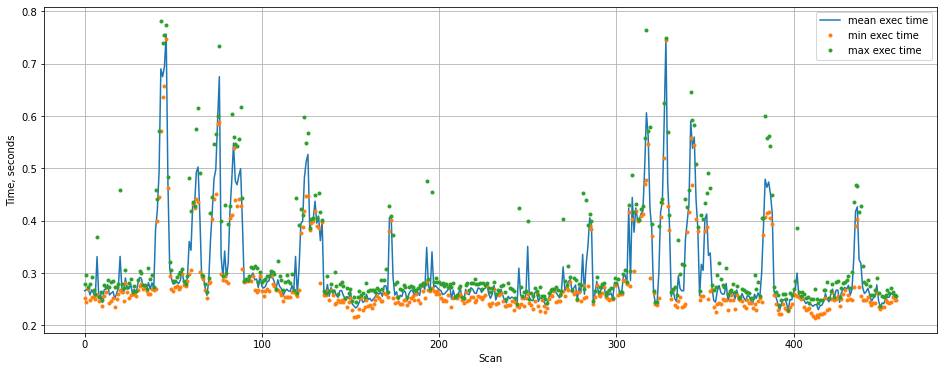

In [397]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.legend()
plt.show()

In [401]:
time_stat = list(exec_time_dct.values())
print('Min process time {}s'.format(min(oy_mean)))
print('Mean process time {}s'.format(np.mean(oy_mean)))
print('Std process time {}s'.format(np.std(oy_mean)))
print('Max process time {}s'.format(max(oy_mean)))

Min process time 0.22779733333333332s
Mean process time 0.30215845606390707s
Std process time 0.0863735799964281s
Max process time 0.756913s
